# Entanglement entropy and Mutual Information analysis of Tmaze Active Inference Tensor Network




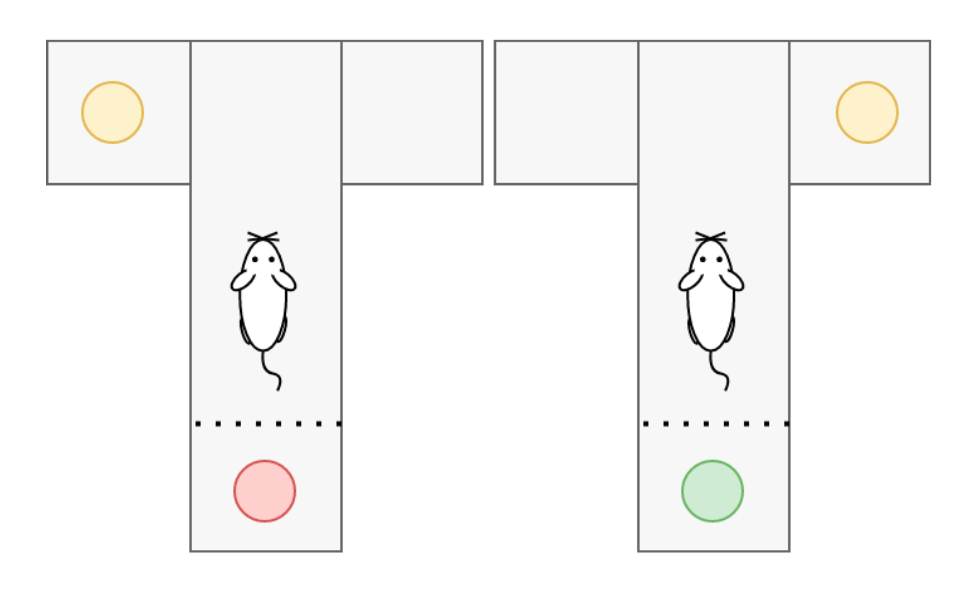







### A mouse has 24 possible observations given by its position [center, right, left, cue(down)] x reward [No reward, Win, Loss] x context [right, left]. The context determines in which position the reward is to be found. It is random, unless the mouse is in the cue position. The mouse has 4 actions [center, right, left, cue(down)]. The environment only runs for two time steps, so only two actions are performed


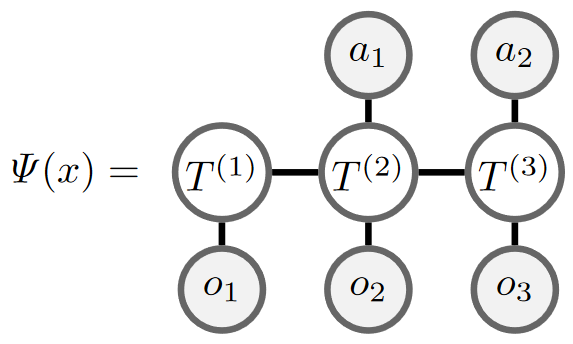

### A tensor network was trained to learn the generative model: P(o,a) of all possible actions and observations in the Tmaze environment. https://link.springer.com/content/pdf/10.1007%2F978-3-031-28719-0_20.pdf
### I will use the insights from https://arxiv.org/abs/2401.00867 to analyze the dependence (entanglement) between these variables. The objective is to show how Empowerment increases as information is gained.

In [1]:
%pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Note: you may need to restart the kernel to use updated packages.


### Load data

In [ ]:
import torch as t
import tensornetwork as tn
import numpy as np
import os

# Specify the path to the .pt file
dataset = "model-0001.pt"

file_path = 'Saved_Models/' + dataset

# Load the .pt file
mps = t.load(file_path, weights_only=False)
T1,T2,T3 = mps.matrices

T1 = T1.numpy()
T2 = T2.numpy()
T3 = T3.numpy()

# Remove extra dimension that is not needed
T1 = T1.reshape(4,24,-1 )
T3 = T3.reshape(-1,4,24 )
print(T1.shape, T2.shape, T3.shape)

(4, 24, 4) (4, 4, 24, 9) (9, 4, 24)


# Compute Reduced Density Matrix (RDM)
### An RDM is a description of a quantum subsystem, that contains information about iits entanglement to the rest of the total system. In our case, each variable is considered to be a subsystem. The RDM is obtained by summing over the other variables and ending up with a sort of Covariance matrix of our variables of interest. The Von Neumann entropy of an RDM is a measure of its entanglement with its environment (all other variables). It tells us if this variable is dependent on other variables and thus, if we can make predictions about it given the other variables (or vice versa).
### The formula is the negative trace of the RDM * log (RDM) or the Shannon entropy of the eigenvalues of the RDM
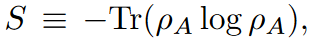
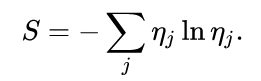

# Convert tensors to the tensornetwork package

In [3]:
import tensornetwork as tn
def tensorNet(mps):

    mps.right_cano() # Use right-canonical form
    # Convert MPS to TensorNetwork
    nodes = []
    conj_nodes = []
    for idx, tensor in enumerate(mps.matrices):
        nodes.append(tn.Node(tensor, name=f"node_{idx}"))
        conj_nodes.append(tn.Node(np.conj(tensor), name=f"conj_node_{idx}"))

    return nodes, conj_nodes

In [4]:
nodes, conj_nodes = tensorNet(mps)
all_nodes = nodes + conj_nodes

# 1. Connect uninformative edges
nodes[0][0] ^ conj_nodes[0][0]
nodes[-1][2] ^ conj_nodes[-1][2]

# Connect physical edges
for i in range(len(nodes)):
    tn.connect(nodes[i][1], conj_nodes[i][1])  # Connect physical edges

# Connect virtual edges
for i in range(len(nodes) - 1):
    tn.connect(nodes[i][2], nodes[i + 1][0])  # Connect right edge of node i to left edge of node i+1
    tn.connect(conj_nodes[i][2], conj_nodes[i + 1][0])  # Same for conjugate nodes

final_node = tn.contractors.auto(all_nodes)
norm = final_node.tensor
print("Normalization check (should be close to 1):", norm)

AttributeError: 'MPSTwo' object has no attribute 'right_cano'

Matrix is Hermitian.
Matrix is positive-definite. Non-zero eigenvalues are: [0.00251473 0.00285099 0.00933419 0.98530008].
Trace of the matrix is 1.
(Entanglement) Entropy :  0.1298125943661878
Maximum Entropy:  2.0


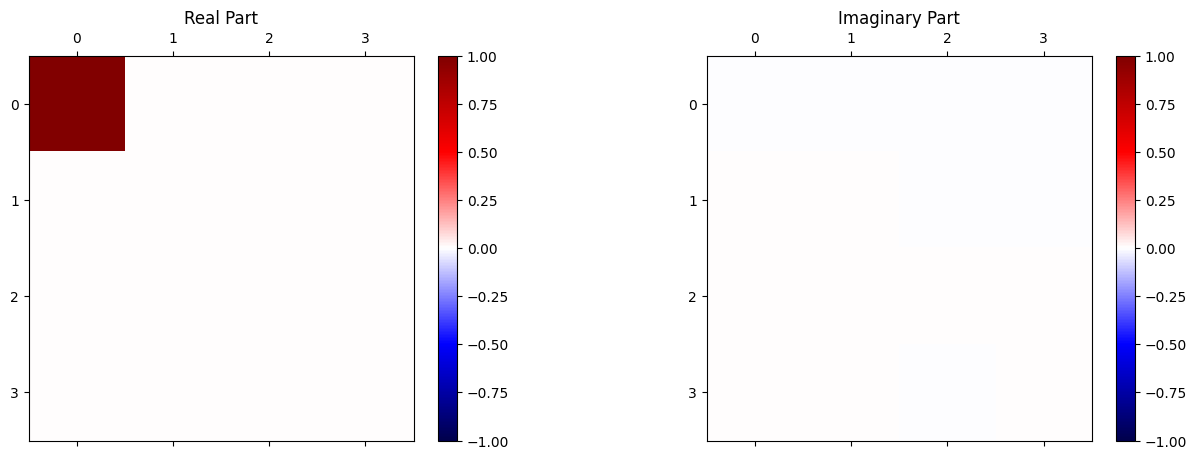

In [5]:
import qiskit.quantum_info as qi
from src import Utils as u
import math

# Contract the tensor network over all indices except action 0 to get the reduced density matrix of action 0
# All other variables are summed over or marginalized in order to study the behaviour of action 0
pa0 = tn.ncon([T1, T1.conj(), T2, T2.conj(), T3, T3.conj()], [(-1,1,2),(-2,1,3),(2,4,5,6),(3,4,5,7),(6,8,9),(7,8,9)])



    
u.inspectRDM(pa0)

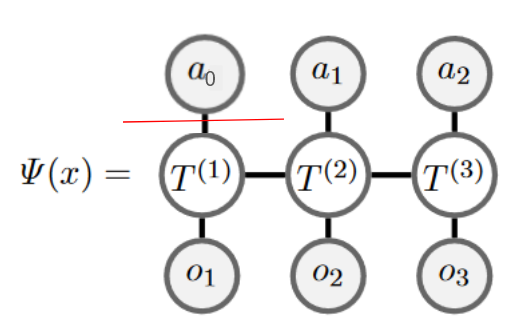

### This action 0 was implemented in the Tensor Network for convenience but does not appear in the Tmaze problem. It was chosen to always be 0 (center). 
### It thus, has no influence on the rest of the variables and shows entropy of 0. It is completely separable (not entangled). It shares no information with the other variables.

### However, it is affecting the entanglement values of the other variables as they are less entangled with their environment because action 0 is considered part of the joint vector space we are exploring. Let us explicitly contract the first tensor with a vector that fixes action0 to be 0 and thus remove the variable from our analysis. All future probabilities will be "given action 0 = 0"

### We have thus removed an uninformative variable through measuring its entanglement entropy. Although after comparing the entropy of the other variables before and after fixing action 0, the values are almost identical as the system is large in comparison to action 0



In [6]:
# Fix action 0 to be 0 (center)
print(T1.shape)
T1 = tn.ncon([T1,np.array([1,0,0,0])],[[1,-1,-2],[1]])
print(T1.shape)

(4, 24, 4)
(24, 4)


# RDM of observation 1

Matrix is Hermitian.
Matrix is positive-definite. Non-zero eigenvalues are: [0.00094274 0.00494904 0.06000245 0.93410577].
Trace of the matrix is 1.
(Entanglement) Entropy :  0.38278028091367106
Maximum Entropy:  4.584962500721157


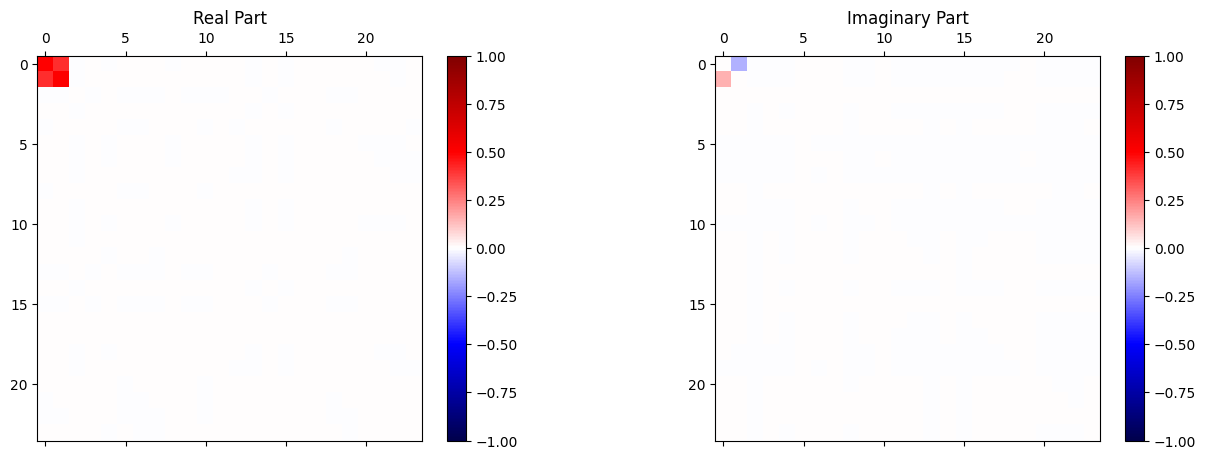

In [7]:
po1 = tn.ncon([T1, T1.conj(), T2, T2.conj(), T3, T3.conj()], [(-1,2),(-2,3),(2,4,5,6),(3,4,5,7),(6,8,9),(7,8,9)])
po1 = po1 / np.trace(po1)
u.inspectRDM(po1)

### The first observation is only slightly entangled with its environment. It would be interesting to find out with which variables it is entangled. One would think that the first observation also would be separable. Maybe the agent would go left in the next action with a higher probability if the context was left. This would mean that all the entanglement of o1 (0.139) was between it and a1.  The mutual information between them should be 0.139. 
### Observation 1 is: position == center, reward == No reward, Cue == Equal superposition of right and left 
### Some eigenvalues are negative, but they are almost 0, so its a rounding issue.

### Viewing an entangled density matrix as a linear combination of its eigenvectors may be a useful analysis, but I dont know how exactly yet 

Eigenvalues:
[0.93410577-2.29418655e-17j 0.06000245-5.75402213e-17j
 0.00494904+5.96914001e-20j 0.00094274-2.70839742e-19j]
Statevector([ 6.60852628e-01-2.44024352e-01j,
              7.09631472e-01+0.00000000e+00j,
              5.92348849e-03+5.66128936e-03j,
             -1.85409769e-03+8.86101324e-03j,
             -2.52601967e-16-7.28305783e-17j,
              2.58597606e-18-1.92334403e-16j,
             -2.50001890e-16+1.47977156e-16j,
             -2.76697326e-16+2.42141057e-16j,
             -2.91808318e-16+9.45248204e-17j,
              2.19112378e-17+1.80377437e-16j,
             -1.57183367e-17-3.70106765e-17j,
             -3.66214572e-16+7.48246635e-17j,
             -1.16177817e-16+1.57695240e-16j,
             -7.75868772e-17+2.78481505e-16j,
             -6.96367383e-17+2.29972776e-16j,
              1.93508445e-16-2.12365906e-16j,
             -9.13595823e-18-8.36057221e-17j,
              5.48705733e-16-1.17232600e-16j,
              1.31005175e-16-2.59954695e-16j,
  

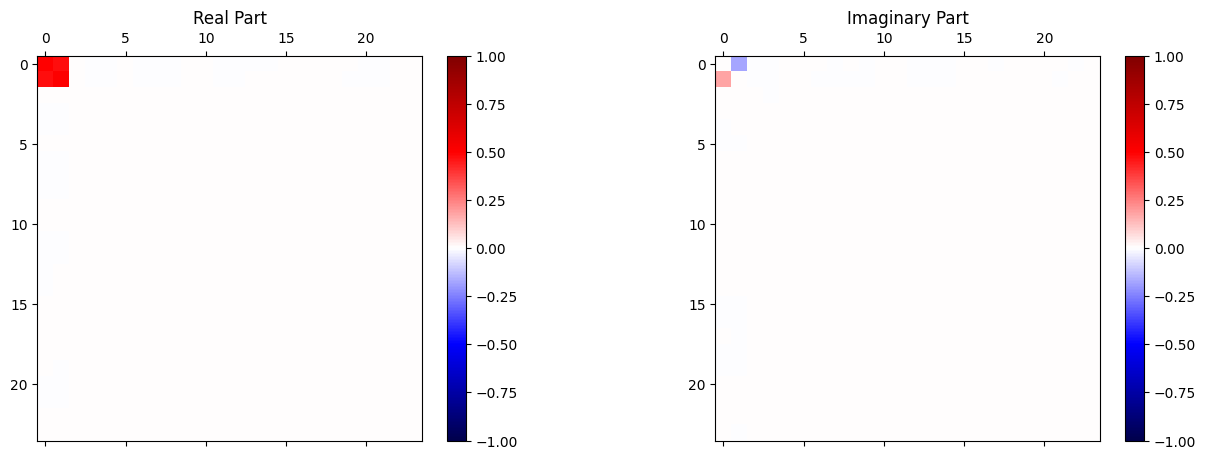

Statevector([ 7.09689139e-01+0.00000000e+00j,
             -6.60851123e-01-2.44010513e-01j,
              1.45521519e-03+3.00171380e-03j,
              5.08077570e-03-6.24874003e-03j,
              1.57433331e-16-1.92918989e-17j,
             -1.58071971e-16+4.92523951e-17j,
              2.35992107e-16-1.43146619e-16j,
              4.06215730e-16-2.19329731e-16j,
              1.32426624e-16+1.50653650e-16j,
             -5.71284047e-17-1.75996468e-16j,
             -9.00592322e-17+2.13613826e-17j,
              2.80123708e-16+1.54829763e-16j,
              1.39135882e-16+4.48252648e-17j,
              1.95336385e-16-1.25903006e-16j,
              1.36225835e-16-9.41943236e-19j,
             -2.79841974e-16+2.15263487e-16j,
             -6.74818627e-17-1.26370572e-16j,
             -5.16251514e-16+1.44623069e-17j,
             -1.79670969e-16+1.99310513e-16j,
              4.13195112e-17+9.39548311e-17j,
              1.62813580e-16-2.73749020e-16j,
              1.24232512e-16-2.122

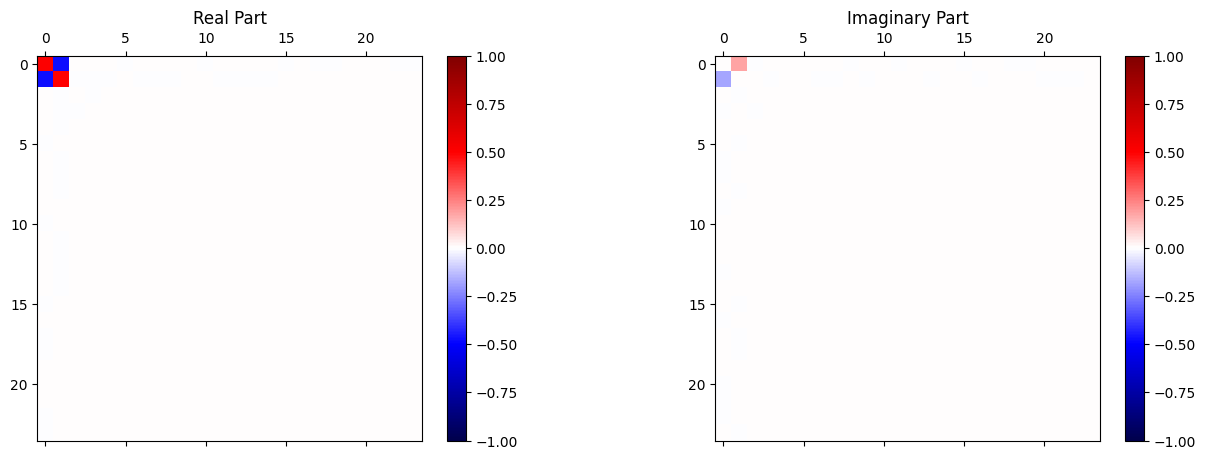

QiskitError: 'Density matrix is not a pure state'

In [8]:
eigenvalues, eigenvectors = np.linalg.eig(po1)

nonZeroEigenvalues = np.abs(eigenvalues) > 1e-6
print("Eigenvalues:")
print(eigenvalues[nonZeroEigenvalues] )

for ev in eigenvectors[nonZeroEigenvalues]:
    density = qi.DensityMatrix(ev)
    print(density.to_statevector(atol=1e-7))
    u.plot_matrix(density.data)

# RDM of action 1

Matrix is Hermitian.
Matrix is positive-definite. Non-zero eigenvalues are: [0.13892346 0.2350845  0.31005833 0.3159337 ].
Trace of the matrix is 1.
(Entanglement) Entropy :  1.9356236750527367
Maximum Entropy:  2.0


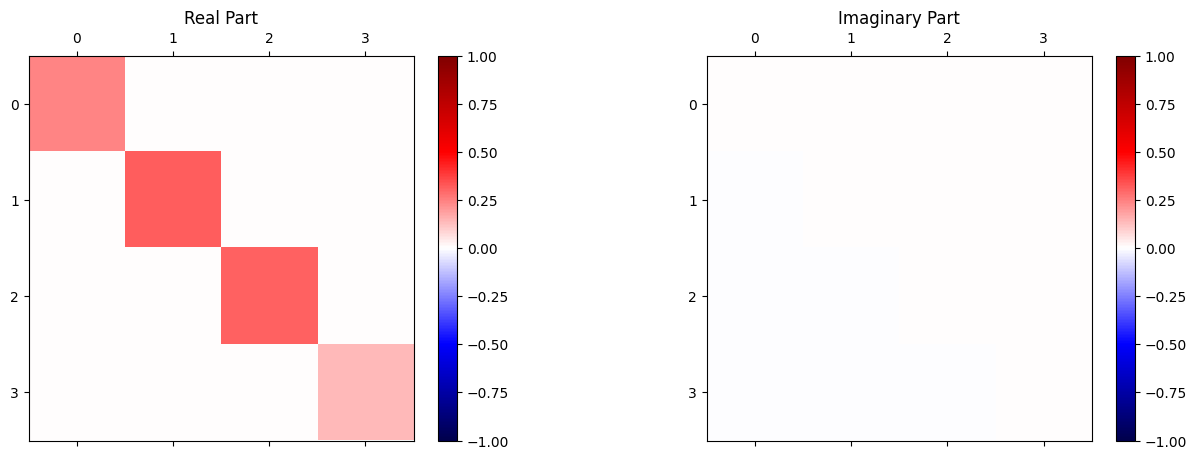

Probabilities [0.23511674 0.31554118 0.31036147 0.13898061]


In [9]:
pa1 = tn.ncon([T1, T1.conj(), T2, T2.conj(), T3, T3.conj()], [(2,3),(2,4),(3,-1,5,6),(4,-2,5,7),(6,8,9),(7,8,9)])
pa1 = pa1 / np.trace(pa1)
u.inspectRDM(pa1)
print("Probabilities",qi.DensityMatrix(pa1).probabilities())

### Action 1 is almost maximally entangled. This is due to the deterministic nature of the environment. An action to move to a certain position will always result in the mouse observing itself at that position in the next observation. We thus expect an action and its following observation to be maximally entangled

# RDM of observation 2

Matrix is Hermitian.
Matrix is positive-definite. Non-zero eigenvalues are: [1.63583528e-04 4.00343986e-04 2.43575545e-03 2.64854826e-03
 1.65985852e-02 4.91640992e-02 8.80016318e-02 1.40687642e-01
 1.53765330e-01 1.56227485e-01 1.57273254e-01 2.32633648e-01].
Trace of the matrix is 1.
(Entanglement) Entropy :  2.811757155889041
Maximum Entropy:  4.584962500721157


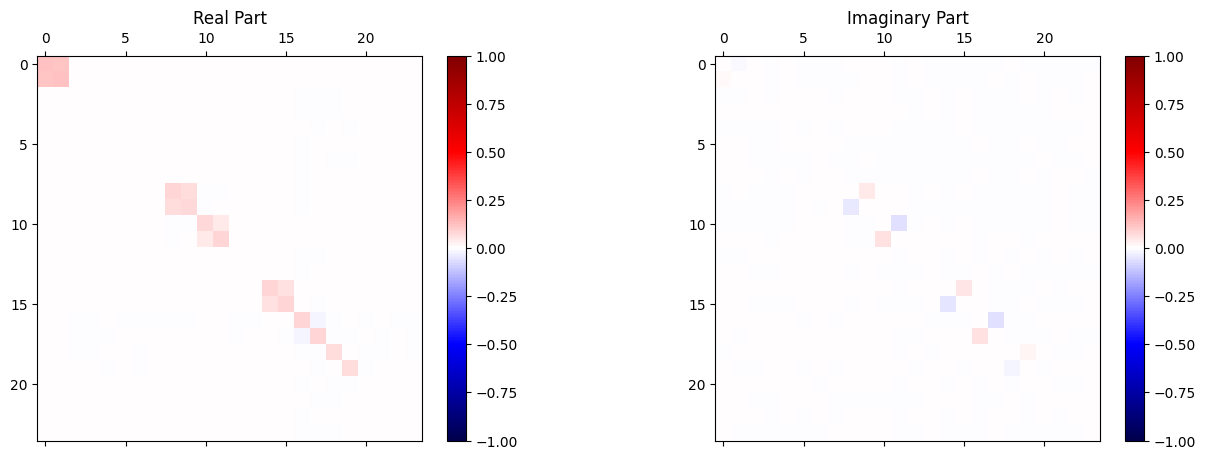

Probabilities [1.17799578e-01 1.17482618e-01 1.71963853e-10 1.37523257e-10
 1.40112860e-10 1.90316727e-10 1.22577373e-10 4.80184496e-11
 7.85397230e-02 7.78508976e-02 7.77746025e-02 7.84269330e-02
 2.57200520e-10 8.27720795e-11 7.87543239e-02 7.89192648e-02
 7.87174465e-02 7.85687879e-02 6.84483280e-02 6.87174029e-02
 1.16463439e-10 1.14693534e-10 1.07782627e-10 1.33451481e-10]


In [ ]:
po2 = tn.ncon([T1, T1.conj(), T2, T2.conj(), T3, T3.conj()], [(2,3),(2,4),(3,5,-1,6),(4,5,-2,7),(6,8,9),(7,8,9)])
u.inspectRDM(po2)
print("Probabilities",qi.DensityMatrix(po2).probabilities())

# Mutual information(MI) between a1 and o2
### MI is the information that is shared among two specific subsystems. Sum of the entropies of the individual systems minus the joint entropy. As the information is counted double, I will divided the MI by two in order to properly interpret the MI as shared information (in bits or nats depending on the base of the logarithm)
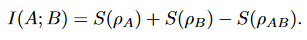

Matrix is Hermitian.
Matrix is positive-definite. Non-zero eigenvalues are: [1.54984208e-04 3.74315712e-04 1.70853949e-03 2.75560735e-03
 3.92526978e-03 1.50940695e-02 4.66086084e-02 1.26413398e-01
 1.41819673e-01 1.55396276e-01 1.65459333e-01 3.40289833e-01].
Trace of the matrix is 1.
(Entanglement) Entropy :  2.5270729349401604
Maximum Entropy:  6.584962500721156


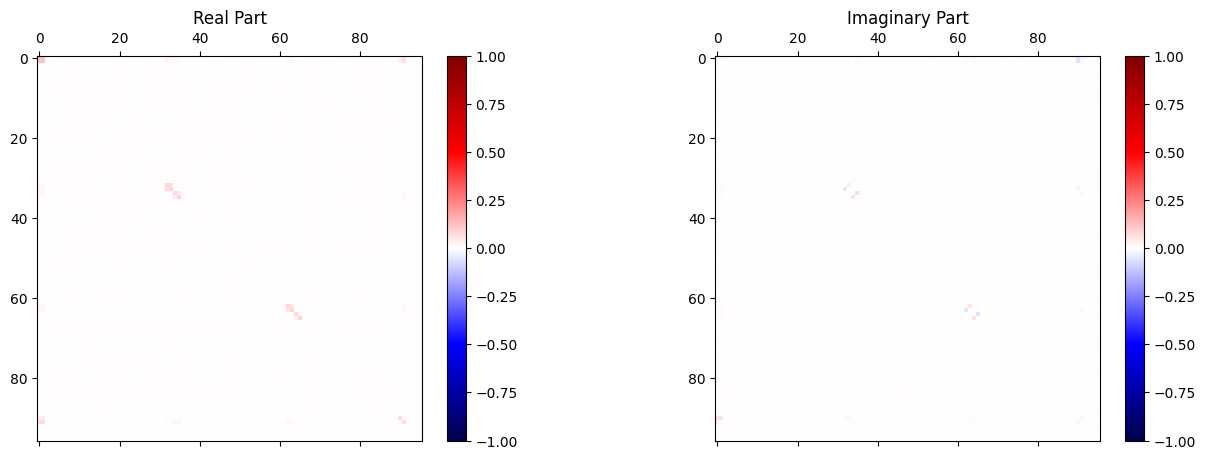

Mutual Information of a1 and o2 1.1091720291361447


In [ ]:
raw_pa1o2 = tn.ncon([T1, T1.conj(), T2, T2.conj(), T3, T3.conj()], [(2,3),(2,4),(3,-1,-2,6),(4,-3,-4,7),(6,8,9),(7,8,9)])
pa1o2 = raw_pa1o2.reshape(24*4,24*4)



u.inspectRDM(pa1o2)
print("Mutual Information of a1 and o2",u.MI(po2,pa1,pa1o2))

### 1.312 bits out of a1s 1.93 total. So a1 must be entangled with another variable aswell. 

# RDM of a2

Matrix is Hermitian.
Matrix is positive-definite. Non-zero eigenvalues are: [0.11658746 0.17622915 0.24043854 0.46674476].
Trace of the matrix is 1.
(Entanglement) Entropy :  1.810336792652116
Maximum Entropy:  2.0


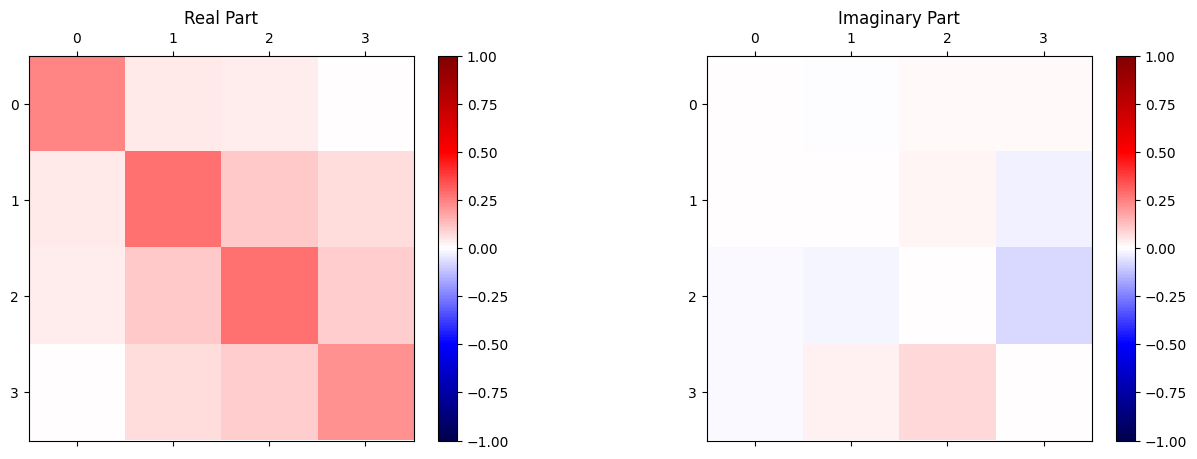

Probabilities [0.23545269 0.27379829 0.27458928 0.21615964]


In [ ]:
pa2 = tn.ncon([T1, T1.conj(), T2, T2.conj(), T3, T3.conj()], [(2,3),(2,4),(3,5,6,7),(4,5,6,8),(7,-1,9),(8,-2,9)])
u.inspectRDM(pa2)
print("Probabilities",qi.DensityMatrix(pa2).probabilities())

# RDM of o3

Matrix is Hermitian.
Matrix is positive-definite. Non-zero eigenvalues are: [2.81631885e-05 9.72583038e-03 2.83225115e-02 3.81649518e-02
 4.13395485e-02 4.91821509e-02 5.21025737e-02 7.86673726e-02
 1.36719254e-01 1.37929510e-01 2.12880789e-01 2.14921134e-01].
Trace of the matrix is 1.
(Entanglement) Entropy :  3.044092105455282
Maximum Entropy:  4.584962500721157


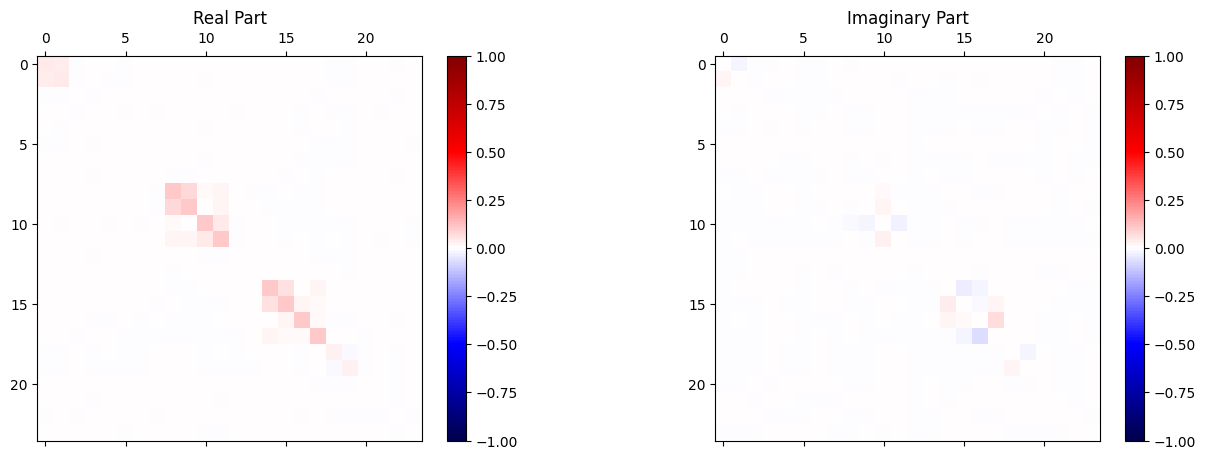

Probabilities [3.92067561e-02 3.94855440e-02 1.28012715e-06 1.86694547e-06
 1.84710645e-06 2.63939989e-06 1.33138342e-06 4.64961076e-06
 1.07863134e-01 1.07189854e-01 1.07379845e-01 1.07621579e-01
 1.47287965e-06 2.40734985e-06 1.08363445e-01 1.08187528e-01
 1.08188740e-01 1.07580309e-01 2.92857661e-02 2.96207263e-02
 4.53566009e-06 2.49441367e-06 1.08344069e-06 1.07326379e-06]


In [ ]:
po3 = tn.ncon([T1, T1.conj(), T2, T2.conj(), T3, T3.conj()], [(2,3),(2,4),(3,5,6,7),(4,5,6,8),(7,9,-1),(8,9,-2)])
u.inspectRDM(po3)
print("Probabilities",qi.DensityMatrix(po3).probabilities())

# MI of a2 and o3

In [ ]:
raw_pa2o3 = tn.ncon([T1, T1.conj(), T2, T2.conj(), T3, T3.conj()], [(2,3),(2,4),(3,5,6,7),(4,5,6,8),(7,-1,-2),(8,-3,-4)])
pa2o3 = raw_pa2o3.reshape(24*4,24*4)

print("Mutual Information of a2 and o3",u.MI(pa2,po3,pa2o3))

Mutual Information of a2 and o3 1.233007555131566


### The entanglement between an action and the observation that directly follows should be entangled if the action is to have any meaning (we assume actions affect our environment). 1.5 bits of the 1.8 total entanglement of a2 is with o3


### Lets take the joint RDM of a1 and o2 and calculate the conditional probability of o2 given a1. That is, what distribution of observations will we see given a particular choice of action? All actions result in a deterministic value for position and reward. The cue is random except when the action to move to the cue is taken. This means we should expect maximal entanglement whenever we go to the cue, as this action is always deterministic, i.e cue action and observation are maximally dependent. Any other action will give a definite position and reward with an equal superposition between cue being left or right. Entanglement has captured the dynamics of the environment.
### This is in principle already readable from the joint RDM but the conditional will make it easier to see. We can either contract the RDM with a matrix that fixes a particular action, or dissect the joint RDM. Normalization is required in both cases to preserve the trace

Matrix is Hermitian.
Matrix is positive-definite. Non-zero eigenvalues are: [0.35842844 0.64157156].
Trace of the matrix is 1.
(Entanglement) Entropy :  0.941371062398192
Maximum Entropy:  4.584962500721157


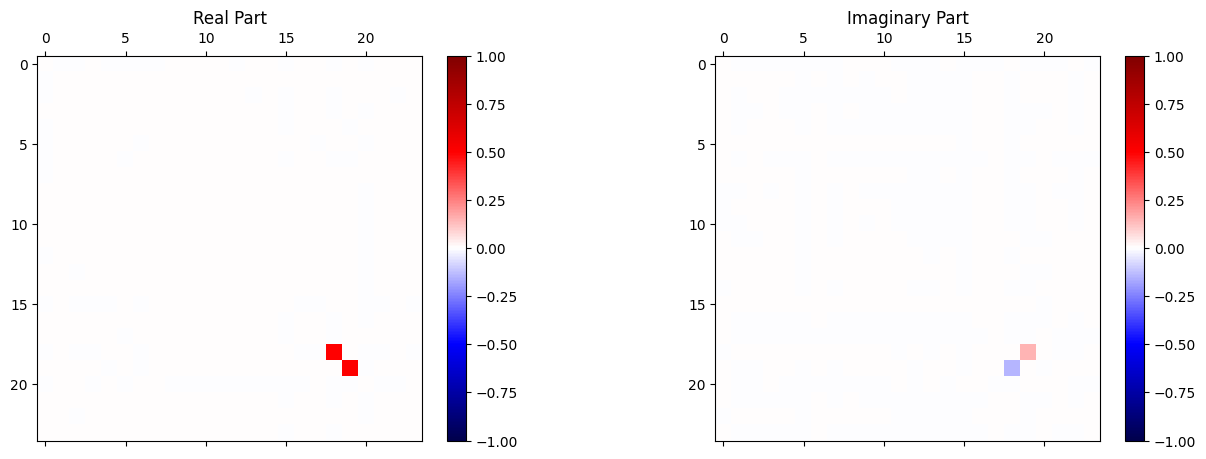

[7.95217922e-11 1.78935268e-10 1.80715959e-10 4.23204675e-10
 3.63872359e-10 6.67367105e-10 4.01132063e-10 1.03948317e-10
 3.50262716e-10 9.39732559e-11 1.23869788e-10 1.89647563e-10
 7.72208320e-10 6.43312199e-11 1.22870813e-10 2.27822306e-10
 4.24869127e-10 2.40438837e-10 4.99019159e-01 5.00980836e-01
 1.24049854e-11 1.82081684e-10 2.40071497e-10 9.33020054e-11]


In [ ]:
# center_a1o2 = tn.ncon([raw_pa1o2,np.diag([0,1,0,0])],[(1,-1,2,-2),(1,2)])
# print(raw_pa1o2.shape)
# inspectRDM(center_a1o2)
# print(qi.DensityMatrix(center_a1o2).probabilities())
action = 3
fixed_a1o2 = pa1o2[action*24:24*(action+1),action*24:24*(action+1)]
fixed_a1o2 = fixed_a1o2/np.trace(fixed_a1o2)
u.inspectRDM(fixed_a1o2)
print(qi.DensityMatrix(fixed_a1o2).probabilities())

### If we choose a1 to be 0 (center) o2 has 0 entropy (0.008 due to randomized dataset). This means that o2 is completely independent from the other variables when a1 is fixed at 0. This makes sense as center is a neutral action. If you go right or left, you are stuck and cant leave. If you go to the cue you gain information.

# Conditional probability of actions given Win
### Let us uncover what actions must be taken in order to Win at observation 3. We compute the joint RDM of a1 and a2 and fix o3 to a superposition of all states where the reward is a Win, so o3 = 8,9,14,15 where position is right or left, reward is Win and context is right or left.

In [ ]:
raw_pa1a2 = tn.ncon([T1, T1.conj(), T2, T2.conj(), T3, T3.conj()], [(2,3),(2,4),(3,-1,5,6),(4,-3,5,7),(6,-2,9),(7,-4,9)])
pa1a2 = raw_pa1a2.reshape(4*4,4*4)

print("Mutual Information of a1 and a2",u.MI(pa2,pa1,pa1a2))

Mutual Information of a1 and a2 0.13558946378867454


Matrix is Hermitian.
Matrix is positive-definite. Non-zero eigenvalues are: [0.10285961 0.20555305 0.69158177].
Trace of the matrix is 1.
(Entanglement) Entropy :  1.1747174856476723
Maximum Entropy:  4.0


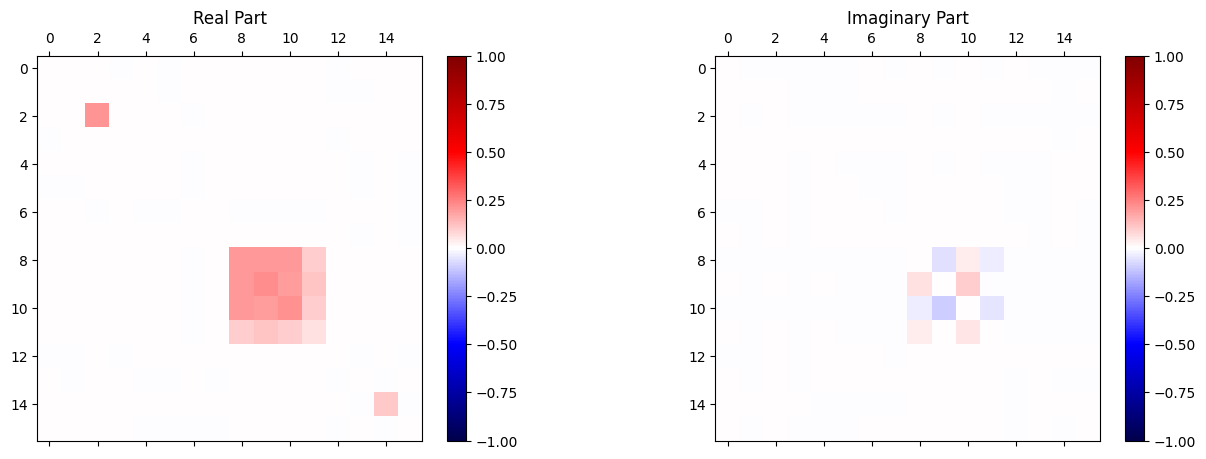

[3.84585772e-07 2.12180739e-07 2.05552549e-01 3.37580894e-07
 1.53355945e-07 1.52320595e-07 1.41339075e-06 2.27945941e-07
 1.98507530e-01 2.23691479e-01 2.11852163e-01 5.75323185e-02
 1.26767900e-06 2.26915708e-07 1.02856638e-01 2.94782851e-06]


In [ ]:
fixedWin = np.zeros(24)
# fixedWin[8] = 1
# fixedWin[9] = 1
fixedWin[14] = 1
fixedWin[15] = 1  
fixedWin = np.outer(fixedWin,fixedWin)

raw_fixed_pa1a2 = tn.ncon([T1, T1.conj(), T2, T2.conj(), T3, T3.conj(), fixedWin], [(2,3),(2,4),(3,-1,5,6),(4,-3,5,7),(6,-2,9),(7,-4,10),(9,10)])
fixed_pa1a2 = raw_fixed_pa1a2.reshape(4*4,4*4)
fixed_pa1a2 = fixed_pa1a2/np.trace(fixed_pa1a2)

u.inspectRDM(fixed_pa1a2)
print(qi.DensityMatrix(fixed_pa1a2).probabilities())

### When we fix o3 to be 14 and 15, so when the Win is reached in the left, the highest probabilities correspond to:
###  a1=center, a2=left: 0.176
###  a1=left, a2=center: 0.162377
###  a1=left, a2=right: 0.041
###  a1=left, a2=left: 0.2189
###  a1=left, a2=cue: 0.2183
###  a1=cue, a2=left: 0.095

### This makes sense. All policies that choose left first are stuck there. All policies that go left but dont get stuck in right first are also high probability.

# Full graph of entropy and Mutual information

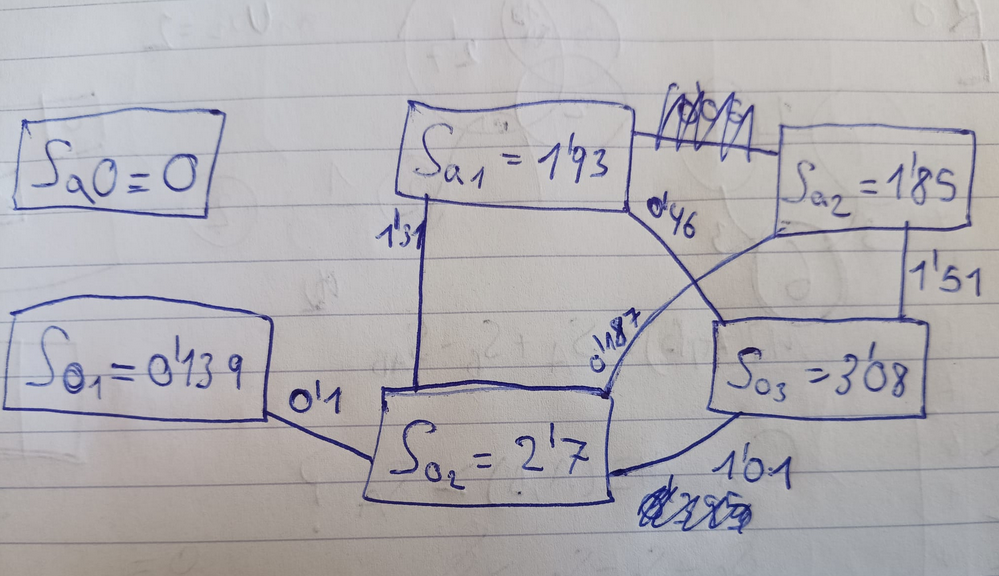